In [116]:
import polars as pl 
import sys
from pathlib import Path
import importlib
import matplotlib.pyplot as plt
import numpy as np 

# Set the font family to Arial
# https://g.co/gemini/share/3898a74b2d77
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial'] # Add Arial to the sans-serif list

plt.rcParams.update({
    'font.size': 20,
})

REFERENCE_GENOME = "hg38"
TILE_SIZE = 1000
METH_READ_PHASED_DIR = Path('/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs')
SAMPLE = '200081' 
BED_METH = f"{METH_READ_PHASED_DIR}/{SAMPLE}.dna-methylation.founder-phased.all_cpgs.bed"

REPO_DIR = Path("/scratch/ucgd/lustre-labs/quinlan/u6018199/tapestry")
sys.path.append(str(REPO_DIR / "src" / "util"))

DELTA_METH_THRESHOLD = 0.9 

## Tile the genome 

In [2]:
import tile
importlib.reload(tile)
from tile import get_tiles 

DF_TILES = get_tiles(REFERENCE_GENOME, TILE_SIZE)
DF_TILES

chrom,start,end
str,i64,i64
"""chr1""",0,1000
"""chr1""",1000,2000
"""chr1""",2000,3000
"""chr1""",3000,4000
"""chr1""",4000,5000
…,…,…
"""chrM""",11000,12000
"""chrM""",12000,13000
"""chrM""",13000,14000


## [Single Sample] Fetch phased and unphased DNA methylation at all CpG sites in the reference and sample genome

In [23]:
import read_data
importlib.reload(read_data)
from read_data import read_tapestry

DF_METH = read_tapestry(BED_METH)
DF_METH

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,is_within_50bp_of_mismatch_site
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool
"""chr1""",10468,10469,13,0.769,0.868,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10470,10471,13,0.769,0.878,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10483,10484,13,0.923,0.929,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10488,10489,14,1.0,0.95,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10492,10493,13,1.0,0.964,null,null,null,null,null,null,null,null,null,null,null,null,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chrY""",56887399,56887400,38,0.737,0.942,null,null,null,null,null,null,null,null,null,null,null,null,null
"""chrY""",56887579,56887580,38,0.895,0.945,null,null,null,null,null,null,null,null,null,null,null,null,null
"""chrY""",56887581,56887582,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


## [Single Sample] Compute difference in methylation between haplotypes in tiles

In [74]:
import methylation
importlib.reload(methylation)
from methylation import compute_methylation

DF_TILES_WITH_METH = compute_methylation(DF_TILES, DF_METH)

In [75]:
DF_TILES_WITH_METH

chrom,start,end,num_cpgs,founder_pat,founder_mat,count_based_meth,model_based_meth,count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,model_based_meth_mat
str,i64,i64,u32,list[str],list[str],f64,f64,f64,f64,f64,f64
"""chr1""",10000,11000,93,[null],[null],0.724176,0.768044,null,null,null,null
"""chr1""",11000,12000,49,[null],[null],0.700417,0.787375,null,null,null,null
"""chr1""",12000,13000,22,[null],[null],0.75381,0.841857,null,null,null,null
"""chr1""",13000,14000,16,[null],[null],0.537933,0.628267,null,null,null,null
"""chr1""",14000,15000,25,[null],[null],0.759708,0.852542,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…
"""chrY""",56883000,56884000,7,[null],[null],0.6222,0.7446,null,null,null,null
"""chrY""",56884000,56885000,12,[null],[null],0.7378,0.846,null,null,null,null
"""chrY""",56885000,56886000,14,[null],[null],0.755846,0.856923,null,null,null,null


Text(0, 0.5, 'Number of tiles')

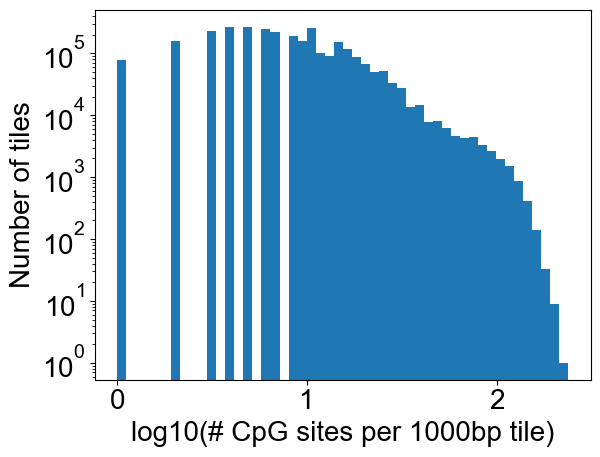

In [76]:
plt.hist(
    np.log10(DF_TILES_WITH_METH["num_cpgs"]), 
    bins=50, # type: ignore
    alpha=None, 
    label=None,
    color=None
)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel(f'log10(# CpG sites per {TILE_SIZE}bp tile)')
plt.ylabel('Number of tiles')

In [77]:
DF_TILES_WITH_METH.filter(pl.col('count_based_meth_pat').is_not_null())

chrom,start,end,num_cpgs,founder_pat,founder_mat,count_based_meth,model_based_meth,count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,model_based_meth_mat
str,i64,i64,u32,list[str],list[str],f64,f64,f64,f64,f64,f64
"""chr1""",499000,500000,7,"[""B"", null]","[""I"", null]",0.799667,0.933333,0.815,0.941667,0.851667,0.9385
"""chr1""",500000,501000,7,"[""B""]","[""I""]",0.748,0.890143,0.734857,0.908286,0.752143,0.855143
"""chr1""",501000,502000,6,"[null, ""B""]","[null, ""I""]",0.734,0.887,0.806,0.95525,0.71025,0.83525
"""chr1""",502000,503000,9,"[""B""]","[""I""]",0.769111,0.904556,0.767,0.947667,0.762667,0.870556
"""chr1""",503000,504000,10,"[""B""]","[""I""]",0.8159,0.9336,0.8662,0.9469,0.799,0.9372
…,…,…,…,…,…,…,…,…,…,…,…
"""chrX""",155654000,155655000,1,"[""A""]","[""K""]",0.657,0.85,0.727,0.921,0.538,0.724
"""chrX""",155655000,155656000,6,"[""A"", null]","[null, ""K""]",0.6986,0.8356,0.796,0.9466,0.5536,0.6064
"""chrX""",155656000,155657000,6,"[""A""]","[""K""]",0.702167,0.8265,0.784333,0.946333,0.595,0.679667


In [100]:
import methylation
importlib.reload(methylation)
from methylation import compute_delta_methylation

DF_TILES_WITH_DELTA_METH = compute_delta_methylation(DF_TILES_WITH_METH)
DF_TILES_WITH_DELTA_METH.filter(pl.col('delta_of_count_based_meth').is_not_null())

chrom,start,end,founder_pat,founder_mat,count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,model_based_meth_mat,delta_of_count_based_meth,delta_of_model_based_meth
str,i64,i64,list[str],list[str],f64,f64,f64,f64,f64,f64
"""chr1""",499000,500000,"[""B"", null]","[""I"", null]",0.815,0.941667,0.851667,0.9385,-0.036667,0.003167
"""chr1""",500000,501000,"[""B""]","[""I""]",0.734857,0.908286,0.752143,0.855143,-0.017286,0.053143
"""chr1""",501000,502000,"[null, ""B""]","[null, ""I""]",0.806,0.95525,0.71025,0.83525,0.09575,0.12
"""chr1""",502000,503000,"[""B""]","[""I""]",0.767,0.947667,0.762667,0.870556,0.004333,0.077111
"""chr1""",503000,504000,"[""B""]","[""I""]",0.8662,0.9469,0.799,0.9372,0.0672,0.0097
…,…,…,…,…,…,…,…,…,…,…
"""chrX""",155654000,155655000,"[""A""]","[""K""]",0.727,0.921,0.538,0.724,0.189,0.197
"""chrX""",155655000,155656000,"[""A"", null]","[null, ""K""]",0.796,0.9466,0.5536,0.6064,0.2424,0.3402
"""chrX""",155656000,155657000,"[""A""]","[""K""]",0.784333,0.946333,0.595,0.679667,0.189333,0.266667


## [All Samples] Compute difference of haplotype-specific methylations for all samples 

In [109]:
import imprinting 
importlib.reload(imprinting)
from imprinting import compute_delta_methylation_all_samples

DF_DELTA_METH_ALL_SAMPLES = compute_delta_methylation_all_samples(REFERENCE_GENOME, TILE_SIZE, METH_READ_PHASED_DIR)
DF_DELTA_METH_ALL_SAMPLES

 42%|████▏     | 10/24 [09:58<13:48, 59.21s/it]

Could not read CpG sites at which count- and model-based methylation levels have been phased to founder haplotypes
Required file does not exist: '/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs/200080.dna-methylation.founder-phased.all_cpgs.bed'
This may be because this sample is a founder and therefore cannot be inheritance-based phased


 71%|███████   | 17/24 [15:26<06:07, 52.54s/it]

Could not read CpG sites at which count- and model-based methylation levels have been phased to founder haplotypes
Required file does not exist: '/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs/200100.dna-methylation.founder-phased.all_cpgs.bed'
This may be because this sample is a founder and therefore cannot be inheritance-based phased


100%|██████████| 24/24 [21:39<00:00, 54.16s/it]


chrom,start,end,NA12877_count,NA12877_model,NA12878_count,NA12878_model,NA12887_count,NA12887_model,NA12885_count,NA12885_model,NA12883_count,NA12883_model,NA12881_count,NA12881_model,NA12879_count,NA12879_model,NA12886_count,NA12886_model,NA12884_count,NA12884_model,NA12882_count,NA12882_model,200081_count,200081_model,200082_count,200082_model,200084_count,200084_model,200085_count,200085_model,200086_count,200086_model,200087_count,200087_model,200101_count,200101_model,200102_count,200102_model,200103_count,200103_model,200104_count,200104_model,200105_count,200105_model,200106_count,200106_model
str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""chr1""",10000,11000,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""chr1""",11000,12000,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""chr1""",12000,13000,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""chr1""",13000,14000,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""chr1""",14000,15000,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chrY""",56883000,56884000,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""chrY""",56884000,56885000,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""chrY""",56885000,56886000,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [ ]:
from write_data import write_dataframe_to_bed

write_dataframe_to_bed(DF_DELTA_METH_ALL_SAMPLES, 'delta_meth_all_samples.bed')

## [All Samples] Find imprinted loci and check for consistency across samples

In [121]:
def filter_to_imprinted_loci(df):
    delta_meth_cols = [col for col in df.columns if col not in ['chrom', 'start', 'end']]
    df = df.filter(pl.any_horizontal(pl.col(delta_meth_cols).abs() > DELTA_METH_THRESHOLD))
    # abs_value_exprs = [pl.col(col).abs() for col in delta_meth_cols]
    # df = df.with_columns(max_abs_value = pl.max_horizontal(abs_value_exprs))    
    return df

filter_to_imprinted_loci(DF_DELTA_METH_ALL_SAMPLES)

chrom,start,end,NA12877_count,NA12877_model,NA12878_count,NA12878_model,NA12887_count,NA12887_model,NA12885_count,NA12885_model,NA12883_count,NA12883_model,NA12881_count,NA12881_model,NA12879_count,NA12879_model,NA12886_count,NA12886_model,NA12884_count,NA12884_model,NA12882_count,NA12882_model,200081_count,200081_model,200082_count,200082_model,200084_count,200084_model,200085_count,200085_model,200086_count,200086_model,200087_count,200087_model,200101_count,200101_model,200102_count,200102_model,200103_count,200103_model,200104_count,200104_model,200105_count,200105_model,200106_count,200106_model
str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""chr1""",3973000,3974000,-0.048952,-0.046,null,null,0.003571,0.006095,-0.034429,-0.055905,-0.040429,-0.043286,null,null,0.07781,0.082762,-0.066571,-0.065571,-0.034857,-0.054238,null,null,-0.010333,-0.00381,0.152857,0.111429,0.013143,-0.006333,0.043952,0.037667,0.046095,-0.019619,0.089524,0.114,-0.042476,-0.065143,-0.771333,-0.775571,-0.019467,-0.047339,-0.072619,-0.065143,-0.941,-0.899,null,null
"""chr1""",5248000,5249000,0.967,0.852,null,null,null,null,0.944,0.858,0.842,0.866,null,null,null,null,null,null,0.789,0.852,null,null,null,null,0.75,0.884,-0.8,-0.782,0.769,0.799,-0.036,0.147,null,null,null,null,0.708,0.791,null,null,null,null,0.846,0.82,0.882,0.863
"""chr1""",5339000,5340000,-0.1305,-0.1399,0.033,0.004333,0.1641,0.1905,0.084111,0.017444,0.075444,-0.005778,0.1617,0.2037,-0.033556,-0.078667,-0.026778,-0.024222,-0.031222,-0.079778,0.1005,0.1688,0.1572,0.1459,-0.9,-0.913,0.1999,0.1571,-0.005222,-0.033444,-0.090778,-0.082333,null,null,-0.1695,-0.213,-0.003444,-0.003222,-0.0498,-0.0624,-0.0923,-0.1104,-0.1404,-0.1552,0.012778,0.021778
"""chr1""",12222000,12223000,null,null,-0.86,-0.896,null,null,null,null,null,null,-0.733,-0.878,null,null,null,null,null,null,0.727,0.861,-0.769,-0.901,-0.625,-0.762,null,null,-0.9,-0.892,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""chr1""",12304000,12305000,0.0603,0.0817,null,null,0.032556,0.028778,0.0714,0.0975,0.1669,0.1593,0.0284,0.0836,0.103,0.1026,0.126,0.0833,0.1074,0.1038,0.0635,0.0782,0.1355,0.1325,-0.039444,-0.000556,null,null,0.040333,0.031222,null,null,-0.789,-0.906,-0.011889,0.005333,0.1007,0.0939,-0.030333,-0.007222,-0.0145,0.0568,0.0934,0.0761,0.142,0.1037
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chrX""",148391000,148392000,null,null,-0.831,-0.833,-0.9,-0.883,-0.838,-0.918,null,null,null,null,-0.864,-0.873,null,null,null,null,null,null,0.082,0.008,0.944,0.894,null,null,null,null,0.444,0.528,null,null,null,null,null,null,-0.769,-0.846,-0.846,-0.885,null,null,-0.8,-0.801
"""chrX""",150385000,150386000,null,null,0.791,0.831,0.682,0.718,0.692,0.589,null,null,0.056,-0.004,0.765,0.73,null,null,null,null,null,null,0.929,0.914,0.053,0.269,null,null,null,null,-0.143,-0.017,null,null,null,null,null,null,0.556,0.509,0.786,0.875,null,null,0.909,0.833
"""chrX""",153579000,153580000,null,null,0.013522,0.005087,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.066043,0.085565,null,null,null,null,null,null,0.116391,0.128913,null,null,null,null,null,null,-0.9,-0.903,0.061217,0.040435,null,null,0.019368,0.038241


In [ ]:
# TODO (Tue)
# compute records for which at least N samples have abs(delta_meth) > threshold 
# for each candidate imprinted locus, compute a coarse hist (number_samples_delta_meth_less_-0.5, etc); plot three dimensional vectors? 
# correlate delta_meth with position in pedigree, or plot delta_meth on pedigree (see slide where this idea was described )
# 6. is delta_meth the same for all samples? is meth_pat and meth_mat the same over all samples? compare with "truth set" of imprinted loci here: https://quinlangroup.slack.com/archives/C0803TM7X0X/p1758742312373849
# 7. are there polymorphic loci, where delta-meth varies over samples? and if so, does meth_pat, meth_mat, delta_meth covary with founder haplotype of degree of relationship? 
